# Assessing Model Interpretablity
> Understanding and comparing the rationale behind machine learning model predictions

- toc: true
- branch: master
- badges: true
- comments: true
- categories: [jupyter, ML, interpretability]
- image: images/blog/interpret_blog.png
- hide: false
- search_exclude: false

### Introduction
Given the recent uptick in the number of papers on interpretable models, I thought it would be interesting to create a simple example showing how one can highlight atoms that are predicted to be critical to a particular property or activity.  This example is motivated by the recent paper [Benchmarks for interpretation of QSAR models](https://jcheminf.biomedcentral.com/articles/10.1186/s13321-021-00519-x) by Mariia Matveieva and Pavel Polishchuk.  In this paper, the authors lay out benchmark datasets and evaluation metrics for model interpretability. In this post, we'll build a simple machine learning model and use some techniques implemented in the RDKit to evaluate the contributions of specific atoms in a molecule to a particular activity.  

One of the things I like about the paper by Matveieva and Polishchuk is that it defines some simple cases where the answer is known, and the activity should be explainable.  We will consider the simplest case where we create a model to predict the number of nitrogen atoms in a molecule.  Once we've defined the model, we can systematically remove the contributions of one atom at a time, predict the activity of the modified molecule and see if the predicted activity changes.   The atoms whose absence brings about the largest changes are considered to be the most important.

We begin by importing the necessary Python libraries.

In [1]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import PandasTools
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import SimilarityMaps
from xgboost import XGBRegressor
from tqdm.notebook import tqdm
import numpy as np
import seaborn as sns
import io
from PIL import Image
from sklearn.metrics import roc_curve, roc_auc_score
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import SVG
from collections import defaultdict

### Loading the Data
The [GitHub repo](https://github.com/ci-lab-cz/ibenchmark) for the paper above contains several example datasets. The file N_train_lbl.sdf contains a set of molecules with a data field "activity" containing the number of nitrogen atoms in the molecule.  We will use this as the y value for our predictive model.  It also has a field, "lbls", containing a list of 1 and 0 values, with 1 for nitrogen atoms and 0 for other elements.  We will use this field to evaluate the validity of the importance measures. 

To start, we'll read the training data, convert the "activity" field to an integer, and add a fingerprint column.

In [2]:
df_train = PandasTools.LoadSDF("data/N_train_lbl.sdf.gz")
df_train.activity = df_train.activity.astype(int)
df_train['fp'] = [AllChem.GetMorganFingerprintAsBitVect(x, 2) for x in tqdm(df_train.ROMol)]

  0%|          | 0/6995 [00:00<?, ?it/s]

,N,ids,activity,lbls,ID,ROMol,fp
0,2,"19,23",2,"0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,...",CHEMBL379993,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."

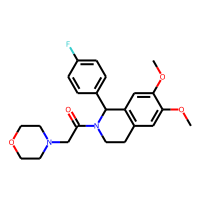

In [3]:
df_train.head(1)

In a similar fashion, we can read the test data, convert the "activity" field to an integer and add a fingerprint column

In [4]:
df_test = PandasTools.LoadSDF("data/N_test_lbl.sdf.gz")
df_test.activity = df_test.activity.astype(int)
df_test['fp'] = [AllChem.GetMorganFingerprintAsBitVect(x, 2) for x in tqdm(df_test.ROMol)]

  0%|          | 0/2999 [00:00<?, ?it/s]

In order to build a model, we need to extract the X and y variables from the training dataframe.

In [5]:
t.rain_X = np.asarray(list(df_train.fp.values))
train_y = df_train.activity.values

### Building a Simple Machine Learning Model
With a few lines of code, we can build an XGBoost regression model. 

In [6]:
xgb = XGBRegressor()

In [7]:
xgb.fit(train_X,train_y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=16, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

Extract the X and y variables from the test dataframe.

In [8]:
test_X = np.asarray(list(df_test.fp.values))
test_y = df_test.activity.values

Predict on the test set

In [9]:
test_pred = xgb.predict(test_X)

Plot the predictions as a violinplot. We could do this as a scatterplot, but a lot of points would be superimposed and it would be difficult to understand the spread of the predictions.

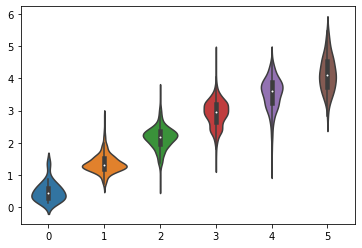

In [10]:
sns.violinplot(x=test_y, y=test_pred);

### Intepreting the Model
Now that we've built a model, we will take a look at one way that we can interpret the model.  We'll start by grabbing the first molecule in the training set.  We notice this molecule has 2 nitrogen atoms, with indices 18 and 22. 

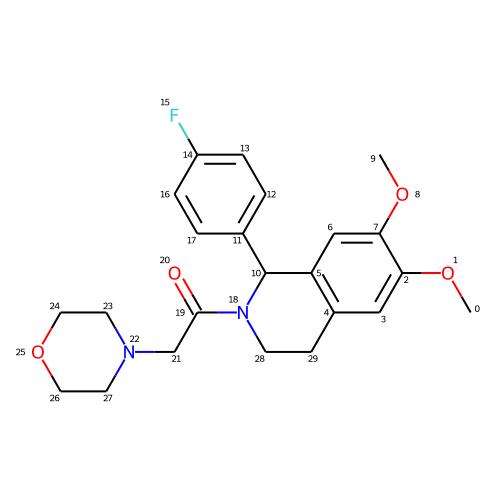

In [11]:
example_mol = Chem.Mol(df_train.ROMol.values[0])
d2d = rdMolDraw2D.MolDraw2DSVG(500,500)
d2d.drawOptions().addAtomIndices=True
d2d.DrawMolecule(example_mol)
d2d.FinishDrawing()
SVG(d2d.GetDrawingText())

We can generate a fingerprint for this molecule and use our model to predict its activity (number of nitrogens).  Note that the number of nitrogens is predicted to be 1.8, rather than 2. 

In [12]:
example_fp = AllChem.GetMorganFingerprintAsBitVect(example_mol,2)
example_pred = xgb.predict(np.array([example_fp]))[0]
example_pred

1.810564

One way of assessing the importance of atoms to a predicted activity is to "mask" each atom and predict the activity using a fingerprint generated with the masked atom.  If the prediction with the "masked" atom is similar to the prediction with the original molecule, that atom has little impact on the prediction.  On the other hand, if masking the atom makes a large change in the prediction, we consider that atom important.  We can use the function **SimilarityMaps.GetMorganFingerprint** to generate a fingerprint with an atom masked.  This function takes two arguments, the input molecule, and the index of the atom to be masked. 

In the code block below, we loop over atoms, generate a fingerprint with each atom masked, and generate a prediction with the masked fingerprint.  At each iteration, we record the predicted activity and "delta", the difference between the activity of the original molecule with no atoms masked and the new molecule with one atom masked.  This data is collected and displayed in a dataframe that is sorted by delta. As we can see in the resulting table, the two nitrogen atoms 18 and 22, have the highest values for delta.

In [13]:
res = []
for atm in example_mol.GetAtoms():
    idx = atm.GetIdx()
    fp = SimilarityMaps.GetMorganFingerprint(example_mol,idx)
    pred_val = xgb.predict(np.array([fp]))[0]
    delta = example_pred - pred_val
    res.append([atm.GetSymbol(),idx,pred_val,delta])
tmp_df = pd.DataFrame(res,columns = ["Atom Type","Atom Index","Predicted Value","Delta"])
tmp_df.sort_values("Delta",ascending=False)

,Atom Type,Atom Index,Predicted Value,Delta
18,N,18,0.631518,1.179046
22,N,22,0.659471,1.151093
21,C,21,1.429062,0.381502
29,C,29,1.438288,0.372276
27,C,27,1.445818,0.364746
23,C,23,1.445818,0.364746
28,C,28,1.523000,0.287564
11,C,11,1.527700,0.282864
10,C,10,1.527700,0.282864
20,O,20,1.533833,0.276731


### Using Similarity Maps to Interpret Models
Now we'll use the **SimilarityMaps** feature from the RDKit to project the importance of each atom onto the chemical structure.  As mentioned above, this method iterates over atoms, removes the contributions of each atom, and uses the model to predict the molecule's activity.  If the activity changes, we consider that atom to be important.  This importance is the used to create a set of weights for atoms that is displayed on top of the structure.  The darker colored atoms are considered to be more important.

Define some functions to display the similarity map for the predictions, mostly lifted from [Greg Landrum's blog post](https://greglandrum.github.io/rdkit-blog/tutorial/2020/01/03/similarity-maps-with-new-drawing-code.html)

In [14]:
def show_png(data):
    bio = io.BytesIO(data)
    img = Image.open(bio)
    return img

def get_pred(fp, pred_function):
    fp = np.array([list(fp)])
    return pred_function(fp)[0]

def plot_similarity_map(mol, model):
    d = Draw.MolDraw2DCairo(400, 400)
    SimilarityMaps.GetSimilarityMapForModel(mol,
                                            SimilarityMaps.GetMorganFingerprint,
                                            lambda x : get_pred(x, model.predict),
                                            draw2d=d)
    d.FinishDrawing()
    return d

Display the similarity map for the predictions.  The variable **test_row** in the table below corresponds to the row in **test_df** that will be displayed. 

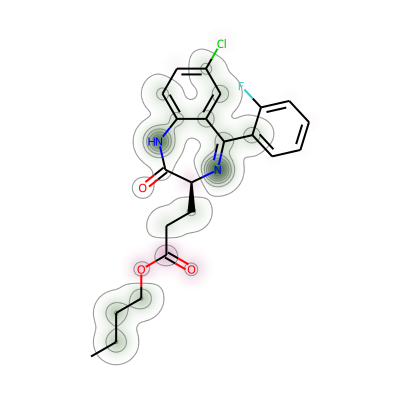

In [15]:
test_row = 1
test_mol = df_test.ROMol.values[test_row]
res = plot_similarity_map(test_mol,xgb);
show_png(res.GetDrawingText())

### Evaluating the Interpretations
In this case we know the "correct" weights for each atom.  Since we're predicting the total number of nitrogen atoms, the nitrogen atoms should have a weight of 1 and the other atoms should have a weight of 0.  We can evaluate the weights produced by the model by comparing them with the weights in the "lbls" column in the input dataframe. To get weights for each atom, we could use the code above.  However, the RDKit provides a simpler solution.  The function **SimilarityMaps.GetAtomicWeightsForModel** wraps the masking operation described above into a single line of code. 

In [16]:
aw = SimilarityMaps.GetAtomicWeightsForModel(test_mol,
                                        SimilarityMaps.GetMorganFingerprint,
                                        lambda x : get_pred(x, xgb.predict))
aw = np.array(aw)

Convert the weights and associated atom types to a dataframe.  For the test molecule in row 1, the two nitrogens have the largest weights. 

In [17]:
wt_df = pd.DataFrame(zip([atm.GetSymbol() for atm in test_mol.GetAtoms()],aw),columns=["Symbol","Weight"])
wt_df.sort_values("Weight",ascending=False)

,Symbol,Weight
10,N,0.964518
26,N,0.764683
2,C,0.289154
3,C,0.289154
1,C,0.289154
11,C,0.235727
20,C,0.222842
12,C,0.218294
19,C,0.214360
25,C,0.184042


Now that we have a way of assigning labels to atoms, we can compare the weights with the "correct" weights, which are in the "lbls" field of the dataframe. 

In [18]:
test_labels = df_test.lbls[test_row]
test_label_array = np.fromstring(test_labels,sep=",",dtype=int)

In [19]:
test_label_array

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0])

There are several ways that we can compare the predicted and actual weights.  One of the simplest is to treat this as a classification problem and calculate the area under the [Receiver Operating Characteristic](https://en.wikipedia.org/wiki/Receiver_operating_characteristic#:~:text=A%20receiver%20operating%20characteristic%20curve,which%20led%20to%20its%20name.) (ROC) curve, which plots the false positive rate vs the true positive rate. 

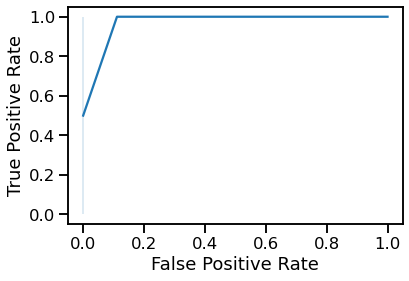

In [20]:
sns.set_context('talk')
fpr, tpr, thresholds = roc_curve(test_label_array, aw)
ax = sns.lineplot(x=fpr,y=tpr)
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate");

We can use sklearn to calculate the [area under the ROC curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html).

In [21]:
roc_auc_score(test_label_array,aw)

1.0

As Matveieva and Polishchuk point out, we're primarily concerned with the identifying the important atoms, and AUC considers the weights on all atoms.  If we're only interested in the "top N" predictions, we can define a score that considers the validity of the relevant predictions.  In this case, that would be the predictions of the nitrogen atoms.  Matveieva and Polishchuk define a top_n score as  
$$
\\
\frac{\sum_{i}m_i}{\sum_{j}n_j}\\
$$
where $m_{i}$ is the total number of ranked atoms in molecule i and $n_{i}$ is the total number of atoms correctly ranked by their contribution.  Here's a quick Python function to calcuate the top_n score for a molecule. 

In [22]:
def top_n(ref, pred):
    n = int(np.sum(ref))
    top_ref_idx = ref.argsort()[-n:][::-1]
    top_pred_idx = pred.argsort()[-n:][::-1]
    num_common = len(set(top_ref_idx).intersection(set(top_pred_idx)))
    return num_common/float(n)

With this function in hand, let's calculate the AUC and top_n score for the first 100 test molecules. We'll also save a list of molecules with a top_n_score < 1.0 so that we can examine then later. 

In [23]:
auc_list = []
top_n_score_list = []
top_n_lt_1_list = []
idx = 0
for mol, label in tqdm(df_test[["ROMol","lbls"]].head(100).values):
    aw = SimilarityMaps.GetAtomicWeightsForModel(mol,
                                        SimilarityMaps.GetMorganFingerprint,
                                        lambda x : get_pred(x, xgb.predict))
    if label != "NA":
        label_array = np.fromstring(label,sep=",",dtype=int)
        auc_list.append(roc_auc_score(label_array,aw))
        top_n_score = top_n(label_array,np.array(aw))
        top_n_score_list.append(top_n_score)
        if top_n_score < 1:
            top_n_lt_1_list.append([idx,top_n_score])
    idx+=1
print(f"Mean AUC = {np.mean(auc_list):.2f}")
print(f"Mean top_n = {np.mean(top_n_score_list):.2f}")

  0%|          | 0/100 [00:00<?, ?it/s]

Mean AUC = 0.99
Mean top_n = 0.93


Create a dataframe with the rows where the top_n score was less than 1. It's interesting that in 15 of 100 cases, we fail to assign the nitrogens atoms as critical features.  

In [24]:
pd.DataFrame(top_n_lt_1_list,columns=["Row","Top_n_score"])

,Row,Top_n_score
0,7,0.500000
1,10,0.500000
2,21,0.666667
3,28,0.750000
4,29,0.800000
5,33,0.666667
6,44,0.666667
7,59,0.333333
8,60,0.000000
9,66,0.500000


Let's define a debugging function that will enable us to compare the top n predictions with the top n labels.

In [25]:
def debug_row(df, idx):
    red = (1,0,0)
    blue = (0,0,1)
    mol = df.loc[[idx]].ROMol.values[0]
    mol = Chem.Mol(mol)
    label = df.loc[idx].lbls
    label_array = np.fromstring(label,sep=",",dtype=int)
    n = int(sum(label_array))        
    aw = SimilarityMaps.GetAtomicWeightsForModel(mol,
                                        SimilarityMaps.GetMorganFingerprint,
                                        lambda x : get_pred(x, xgb.predict))
    aw = np.array(aw)
    top_idx = aw.argsort()[-n:][::-1]
    top_idx = [int(x) for x in top_idx]
    # set the drawing options
    d2d = rdMolDraw2D.MolDraw2DSVG(350,300)
    dos = d2d.drawOptions()
    dos.atomHighlightsAreCircles = True
    dos.fillHighlights=False
    # set the highlight color for the top n predicted atoms to red
    top_dict = defaultdict(list)
    highlight_rads = {}
    for t in top_idx:
        top_dict[t].append(red)
    # set the colors for the top n labeled atoms to red
    for a in label_array.argsort()[-n:]:
        top_dict[int(a)].append(blue)
    # set the radii for the highlight circles
    for k,v in top_dict.items():
        highlight_rads[k] = 0.6
    d2d.DrawMoleculeWithHighlights(mol," ",dict(top_dict),{},highlight_rads,{})
    d2d.FinishDrawing()
    return d2d

Here's the output from our debugging function. Correctly predicted atoms are shown as circles that are half red and half blue. Incorrectly predicted atoms are shown as red circles, atoms that are "missed" are shown as blue circles. 

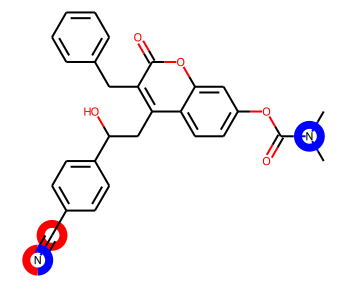

In [26]:
mistake_row = 7
res = debug_row(df_test,mistake_row)
SVG(res.GetDrawingText())  

### Conclusion
Hopefully, this post provides a brief introduction into how models can be interpreted and how the values interpreted from a model can be assessed. There's a lot more to be done here, but hopefully this code provides a place to get started. If you're interested in the critical assessment of model interpretability, I highly recommend these two papers.

Sheridan, Robert P. "Interpretation of QSAR models by coloring atoms according to changes in predicted activity: how robust is it?." Journal of Chemical Information and Modeling 59.4 (2019): 1324-1337. [https://doi.org/10.1021/acs.jcim.8b00825](https://doi.org/10.1021/acs.jcim.8b00825)

Matveieva M, Polishchuk P. Benchmarks for interpretation of QSAR models. Journal of Cheminformatics. 2021 Dec;13(1):1-20. [https://doi.org/10.1186/s13321-021-00519-x](https://doi.org/10.1186/s13321-021-00519-x)